# Collaborative Filtering dan Tren Analisis Penjualan (Prediksi dan Rekomendasi

In [18]:
pip install pandas scikit-learn xgboost matplotlib seaborn

In [23]:
pip install openpyxl

✅ Data berhasil dimuat. Berikut 5 baris pertama:
  Pembeli         Alamat Nama Barang Kemasan    Tanggal  Jumlah Barang  \
0    Dedi   Cappa Galung  Abon Manis  200 Gr 2025-05-31              1   
1    Yuni  Ujung Sabbang  Abon Pedas  200 Gr 2025-04-22              4   
2    Hani  Ujung Sabbang  Abon Pedas  100 Gr 2025-04-10              5   
3    Nana       Bacukiki  Abon Manis  500 Gr 2025-05-24              3   
4    Yuni  Ujung Sabbang  Abon Pedas  100 Gr 2025-04-16              1   

   Harga Satuan   Total  
0         38000   38000  
1         38000  152000  
2         22000  110000  
3         80000  240000  
4         22000   22000  


Data setelah di-preprocess (diubah menjadi angka):
   Pembeli         Alamat  Nama Barang  Kemasan    Tanggal  Jumlah Barang  \
0        4   Cappa Galung            0        2 2025-05-31              1   
1       29  Ujung Sabbang            1        2 2025-04-22              4   
2       11  Ujung Sabbang            1        0 2025-04-10        

<ipython-input-24-32efa6dd9a27>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


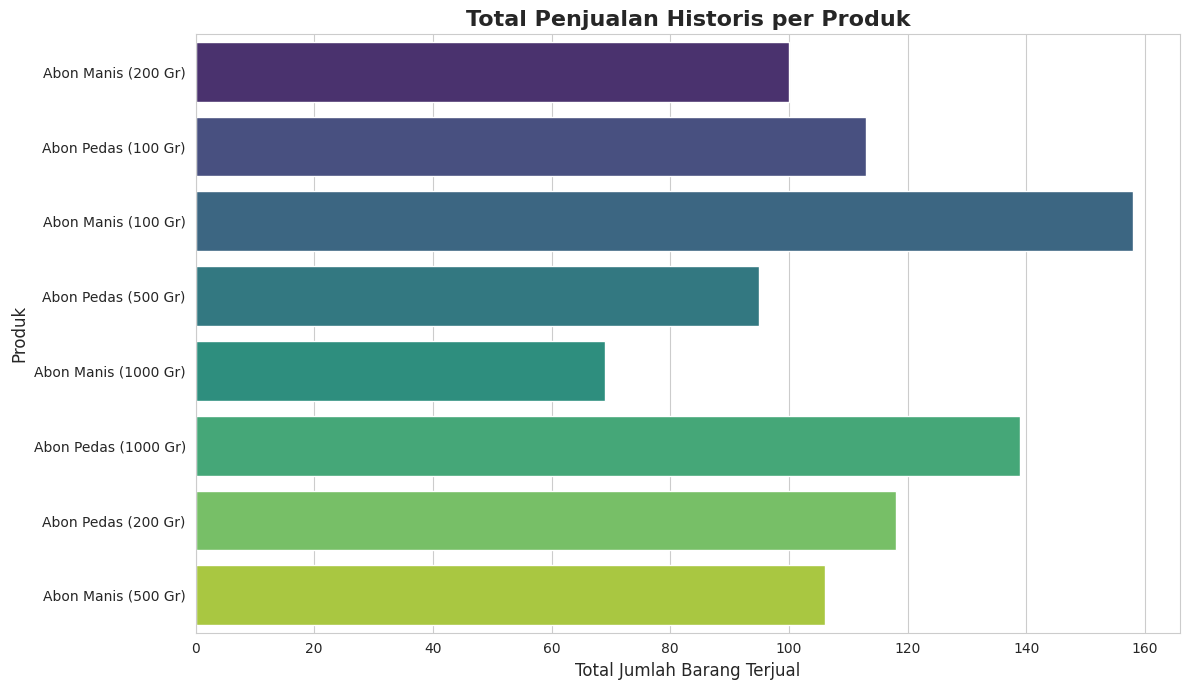

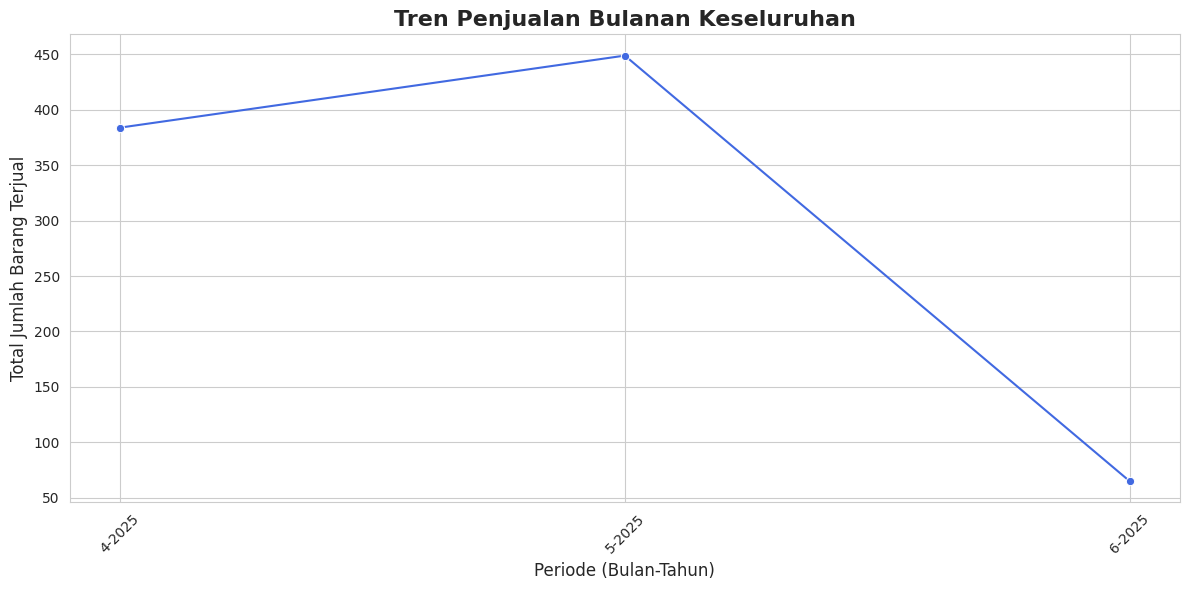



🚀 Memulai pelatihan model XGBoost...
Pelatihan model selesai.
Evaluasi Model - Root Mean Squared Error (RMSE): 1.73
Artinya, rata-rata kesalahan prediksi model adalah sekitar 2 unit barang.


Membuat prediksi untuk tren penjualan di Bulan 7/2025...

✅ HASIL REKOMENDASI & TREN PENJUALAN

Prediksi Total Penjualan per Produk untuk Bulan 7/2025:
  Nama Barang  Kemasan  Prediksi_Jumlah
6  Abon Pedas   200 Gr              108
2  Abon Manis   200 Gr              106
7  Abon Pedas   500 Gr               95
5  Abon Pedas  1000 Gr               84
3  Abon Manis   500 Gr               83
4  Abon Pedas   100 Gr               81
1  Abon Manis  1000 Gr               76
0  Abon Manis   100 Gr               75




<ipython-input-24-32efa6dd9a27>:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


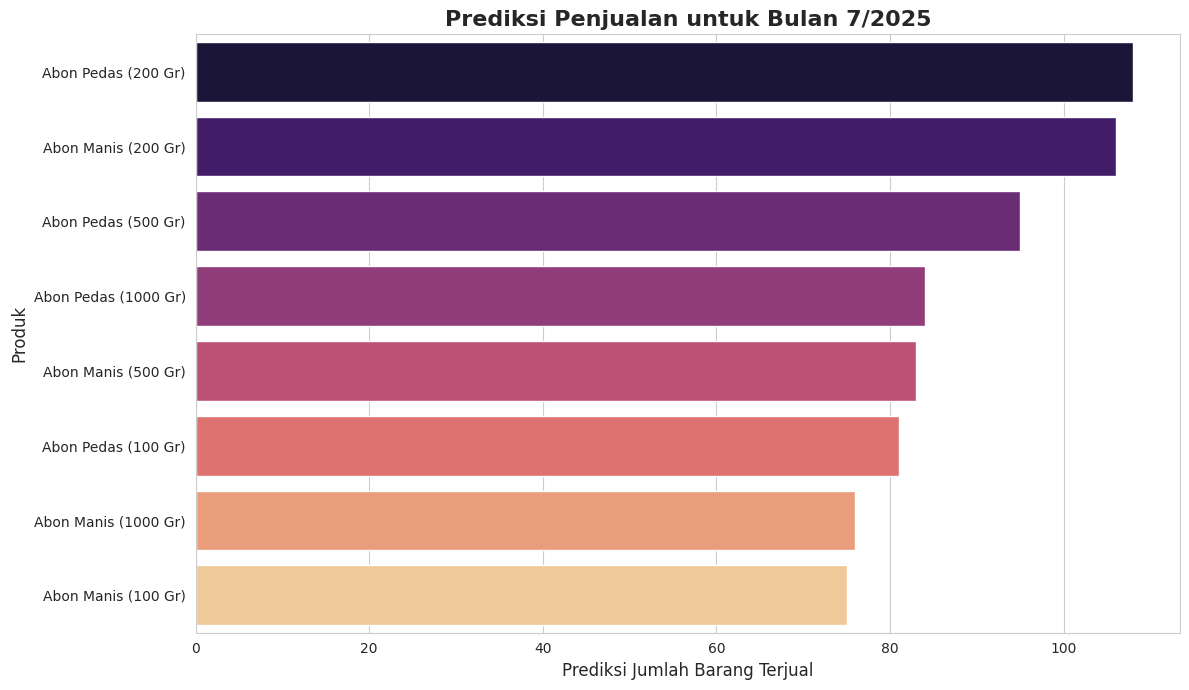

💡 Rekomendasi Utama:
Berdasarkan model prediksi, produk yang berpotensi **paling laku** di Bulan 7/2025 adalah **Abon Pedas** dengan kemasan **200 Gr**.
Toko 'Abon Ummi' disarankan untuk mempersiapkan stok lebih untuk produk tersebut.


In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Memuat dan Mempersiapkan Data ---
# Path ke file Anda
file_path = 'data_dummy_abon_ummi_rev.xlsx'

# Gunakan pd.read_excel() untuk membaca file .xlsx
df = pd.read_excel(file_path)

print("✅ Data berhasil dimuat. Berikut 5 baris pertama:")
print(df.head())
print("\n" + "="*50 + "\n")


# --- 2. Feature Engineering & Preprocessing ---
# Model memerlukan input numerik, jadi kita ubah data teks dan tanggal.

# Ubah Tanggal menjadi fitur Bulan dan Tahun
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
df['Bulan'] = df['Tanggal'].dt.month
df['Tahun'] = df['Tanggal'].dt.year

# Ubah fitur kategorikal menjadi numerik menggunakan LabelEncoder
# Kita simpan encoder-nya untuk menerjemahkan kembali nanti
encoders = {}
for col in ['Pembeli', 'Nama Barang', 'Kemasan']:
    le = LabelEncoder()
    # Mengatasi nilai yang mungkin hilang (NaN) sebelum encoding
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

print("Data setelah di-preprocess (diubah menjadi angka):")
print(df.head())
print("\n" + "="*50 + "\n")


# --- 3. Analisis & Visualisasi Data Historis ---
print("📊 Menganalisis data penjualan historis...")
# Membuat kolom gabungan untuk visualisasi yang lebih jelas
df_viz = df.copy()
for col, le in encoders.items():
    df_viz[col] = le.inverse_transform(df[col]) # Kembalikan ke nama asli
df_viz['Produk'] = df_viz['Nama Barang'] + ' (' + df_viz['Kemasan'] + ')'

# Visualisasi 1: Total Penjualan per Produk
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
sns.barplot(
    data=df_viz.sort_values('Jumlah Barang', ascending=False),
    y='Produk',
    x='Jumlah Barang',
    estimator=sum,
    palette='viridis',
    errorbar=None
)
plt.title('Total Penjualan Historis per Produk', fontsize=16, fontweight='bold')
plt.xlabel('Total Jumlah Barang Terjual', fontsize=12)
plt.ylabel('Produk', fontsize=12)
plt.tight_layout()
plt.show()

# Visualisasi 2: Tren Penjualan Bulanan
penjualan_bulanan = df.groupby(['Tahun', 'Bulan'])['Jumlah Barang'].sum().reset_index()
penjualan_bulanan['Periode'] = penjualan_bulanan['Bulan'].astype(str) + '-' + penjualan_bulanan['Tahun'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=penjualan_bulanan, x='Periode', y='Jumlah Barang', marker='o', color='royalblue')
plt.title('Tren Penjualan Bulanan Keseluruhan', fontsize=16, fontweight='bold')
plt.xlabel('Periode (Bulan-Tahun)', fontsize=12)
plt.ylabel('Total Jumlah Barang Terjual', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("\n" + "="*50 + "\n")


# --- 4. Pelatihan Model XGBoost ---
# Target kita adalah memprediksi 'Jumlah Barang'
y = df['Jumlah Barang']
X = df[['Pembeli', 'Nama Barang', 'Kemasan', 'Bulan', 'Tahun']]

# Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi dan melatih model XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

print("🚀 Memulai pelatihan model XGBoost...")
model.fit(X_train, y_train)
print("Pelatihan model selesai.")

# Evaluasi model pada data uji
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Evaluasi Model - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Artinya, rata-rata kesalahan prediksi model adalah sekitar {rmse:.0f} unit barang.")
print("\n" + "="*50 + "\n")


# --- 5. Membuat Prediksi Tren Penjualan di Masa Depan ---
# Skenario: "Produk apa yang paling berpotensi laku di bulan Juli 2025?"
future_month = 7
future_year = 2025

# Ambil semua kemungkinan kombinasi dari pembeli, barang, dan kemasan
pembeli_ids = df['Pembeli'].unique()
barang_ids = df['Nama Barang'].unique()
kemasan_ids = df['Kemasan'].unique()
future_scenarios = list(itertools.product(pembeli_ids, barang_ids, kemasan_ids))
future_df = pd.DataFrame(future_scenarios, columns=['Pembeli', 'Nama Barang', 'Kemasan'])
future_df['Bulan'] = future_month
future_df['Tahun'] = future_year

# Lakukan prediksi menggunakan model yang sudah dilatih
print(f"Membuat prediksi untuk tren penjualan di Bulan {future_month}/{future_year}...")
future_df['Prediksi_Jumlah'] = model.predict(future_df)
future_df['Prediksi_Jumlah'] = future_df['Prediksi_Jumlah'].apply(lambda x: max(0, round(x))) # Bulatkan dan pastikan tidak negatif

# Terjemahkan kembali ID menjadi nama aslinya
for col, le in encoders.items():
    future_df[col] = le.inverse_transform(future_df[col])

# Kelompokkan untuk melihat total prediksi penjualan
trend_penjualan = future_df.groupby(['Nama Barang', 'Kemasan'])['Prediksi_Jumlah'].sum().reset_index()
trend_penjualan_sorted = trend_penjualan.sort_values(by='Prediksi_Jumlah', ascending=False)


# --- 6. Hasil dan Visualisasi Prediksi ---
print("\n✅ HASIL REKOMENDASI & TREN PENJUALAN\n")
print(f"Prediksi Total Penjualan per Produk untuk Bulan {future_month}/{future_year}:")
print(trend_penjualan_sorted)
print("\n" + "="*50 + "\n")

# Visualisasi 3: Prediksi Penjualan per Produk
trend_penjualan_sorted['Produk'] = trend_penjualan_sorted['Nama Barang'] + ' (' + trend_penjualan_sorted['Kemasan'] + ')'
plt.figure(figsize=(12, 7))
sns.barplot(
    data=trend_penjualan_sorted,
    y='Produk',
    x='Prediksi_Jumlah',
    palette='magma'
)
plt.title(f'Prediksi Penjualan untuk Bulan {future_month}/{future_year}', fontsize=16, fontweight='bold')
plt.xlabel('Prediksi Jumlah Barang Terjual', fontsize=12)
plt.ylabel('Produk', fontsize=12)
plt.tight_layout()
plt.show()

# --- 7. Rekomendasi Final ---
produk_teratas = trend_penjualan_sorted.iloc[0]
print("💡 Rekomendasi Utama:")
print(f"Berdasarkan model prediksi, produk yang berpotensi **paling laku** di Bulan {future_month}/{future_year} adalah **{produk_teratas['Nama Barang']}** dengan kemasan **{produk_teratas['Kemasan']}**.")
print("Toko 'Abon Ummi' disarankan untuk mempersiapkan stok lebih untuk produk tersebut.")